In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

import copy
from collections import namedtuple
import os
import random
import shutil
import time
from datetime import datetime


In [7]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [8]:
ROOT = 'dataset'

data_dir = ROOT
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')
train_data = datasets.ImageFolder(root = train_dir, 
                                  transform = transforms.ToTensor())

# train_data = datasets.ImageFolder(root = train_dir, 
#                                   transform = transforms.ToTensor())

means = torch.zeros(3)
stds = torch.zeros(3)

for img, label in train_data:
    means += torch.mean(img, dim = (1,2))
    stds += torch.std(img, dim = (1,2))

means /= len(train_data)
stds /= len(train_data)
    
print(f'Calculated means: {means}')
print(f'Calculated stds: {stds}')

Calculated means: tensor([0.4847, 0.4662, 0.4570])
Calculated stds: tensor([0.2308, 0.2332, 0.2318])


In [9]:
# from torchvision.transforms import transforms
from torchvision import transforms

pretrained_size = 224
pretrained_means = [0.4847, 0.4662, 0.4570]
pretrained_stds= [0.2308, 0.2332, 0.2316]

train_transforms = transforms.Compose([
                transforms.RandomResizedCrop((224,224),scale=(0.7,1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.AutoAugment(),
                transforms.ToTensor(),
                transforms.Normalize(mean = pretrained_means, std = pretrained_stds)])

test_transforms = transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds) ])

In [10]:
train_data = datasets.ImageFolder(root = train_dir, 
                                  transform = train_transforms)

test_data = datasets.ImageFolder(root = test_dir, 
                                 transform = test_transforms)

                                                                  

In [11]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data, 
                                           [n_train_examples, n_valid_examples])

In [12]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

In [13]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 30758
Number of validation examples: 3418
Number of testing examples: 8546


In [14]:
BATCH_SIZE = 128

train_iterator = data.DataLoader(train_data, 
                                 shuffle = True, 
                                 batch_size = BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data, 
                                 batch_size = BATCH_SIZE)

test_iterator = data.DataLoader(test_data, 
                                batch_size = BATCH_SIZE)

In [15]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image    

In [16]:
def plot_images(images, labels, classes, normalize = True):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (15, 15))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        label = classes[labels[i]]
        ax.set_title(label)
        ax.axis('off')

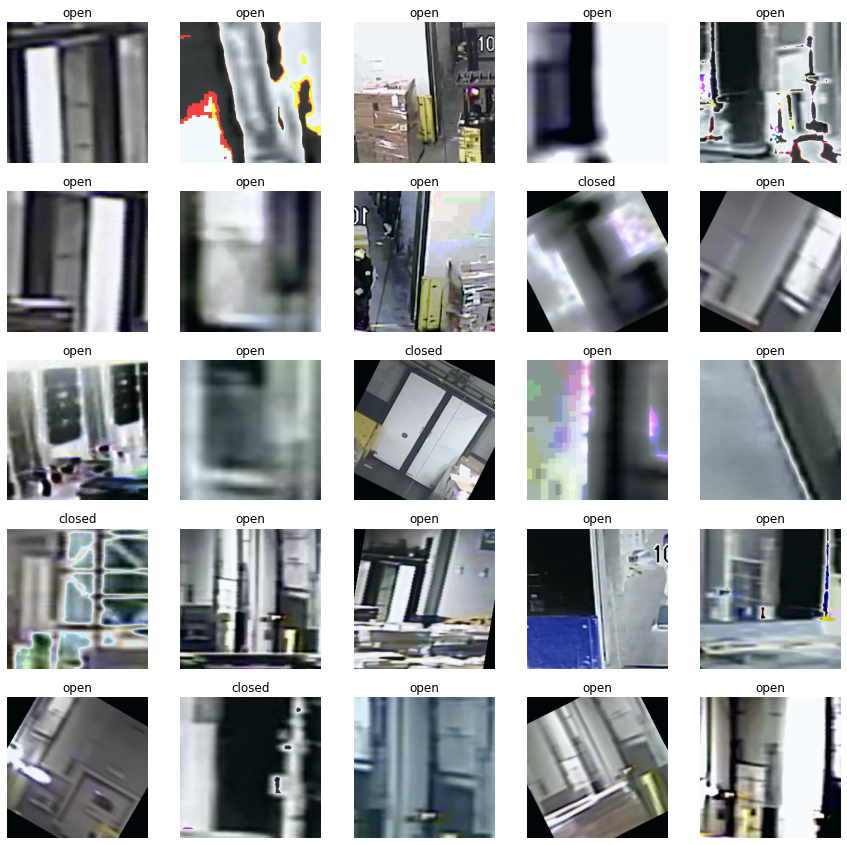

In [12]:
N_IMAGES = 25

images, labels = zip(*[(image, label) for image, label in 
                           [train_data[i] for i in range(N_IMAGES)]])

classes = test_data.classes

plot_images(images, labels, classes)

In [17]:
class ModelEMA(nn.Module):
    def __init__(self, model, decay=0.9999, device=None):
        super(ModelEMA, self).__init__()
        # make a copy of the model for accumulating moving average of weights
        self.module = copy.deepcopy(model)
        self.module.eval()
        self.decay = decay
        self.device = device  # perform ema on different device from model if set
        if self.device is not None:
            self.module.to(device=device)

    def _update(self, model, update_fn):
        with torch.no_grad():
            for ema_v, model_v in zip(self.module.state_dict().values(), model.state_dict().values()):
                if self.device is not None:
                    model_v = model_v.to(device=self.device)
                ema_v.copy_(update_fn(ema_v, model_v))

    def update(self, model):
        self._update(model, update_fn=lambda e, m: self.decay * e + (1. - self.decay) * m)

    def set(self, model):
        self._update(model, update_fn=lambda e, m: m)

In [20]:
# ResNetConfig = namedtuple('ResNetConfig', ['block', 'n_blocks', 'channels'])

# resnet50_config = ResNetConfig(block = Bottleneck,
#                                n_blocks = [3, 4, 6, 3],
#                                channels = [64, 128, 256, 512])

# resnet101_config = ResNetConfig(block = Bottleneck,
#                                 n_blocks = [3, 4, 23, 3],
#                                 channels = [64, 128, 256, 512])

# resnet152_config = ResNetConfig(block = Bottleneck,
#                                 n_blocks = [3, 8, 36, 3],
#                                 channels = [64, 128, 256, 512])

pretrained_model = models.resnet50(pretrained = True)


In [21]:
print(pretrained_model)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

IN_FEATURES = pretrained_model.fc.in_features 
OUTPUT_DIM = len(test_data.classes)
print(OUTPUT_DIM)
print(IN_FEATURES)
fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)
pretrained_model.fc = fc

# model_old = ResNet(resnet50_config, OUTPUT_DIM)
# model_old.load_state_dict(pretrained_model.state_dict())
# model_old = model_old.to(device)

# optimizer_old = optim.Adam(model_old.parameters(), lr=START_LR)


3
2048


In [23]:
# model = ResNet(resnet50_config, OUTPUT_DIM)
n_classes = 3
freeze_layers = False
model = models.resnet50(pretrained = True)
for param in model.parameters():
    param.requires_grad = not(freeze_layers)

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, n_classes)
# model.load_state_dict(pretrained_model.state_dict())


In [24]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 23,514,179 trainable parameters


In [28]:
# 23,514,179
START_LR = 1e-7
LABEL_SMOUTH=False

optimizer = optim.Adam(model.parameters(), lr=START_LR)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if LABEL_SMOUTH==True:
    criterion = nn.CrossEntropyLoss(LABEL_SMOUTH=0.3)
else:
    criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

In [29]:
class LRFinder:
    def __init__(self, model, optimizer, criterion, device):
        
        self.optimizer = optimizer
        self.model = model
        self.criterion = criterion
        self.device = device
        
        torch.save(model.state_dict(), 'init_params.pt')

    def range_test(self, iterator, end_lr = 10, num_iter = 100, 
                   smooth_f = 0.05, diverge_th = 5):
        
        lrs = []
        losses = []
        best_loss = float('inf')

        lr_scheduler = ExponentialLR(self.optimizer, end_lr, num_iter)
        
        iterator = IteratorWrapper(iterator)
        
        for iteration in range(num_iter):

            loss = self._train_batch(iterator)

            #update lr
            lr_scheduler.step()
            
            lrs.append(lr_scheduler.get_lr()[0])

            if iteration > 0:
                loss = smooth_f * loss + (1 - smooth_f) * losses[-1]
                
            if loss < best_loss:
                best_loss = loss

            losses.append(loss)
            
            if loss > diverge_th * best_loss:
                print("Stopping early, the loss has diverged")
                break
                       
        #reset model to initial parameters
        model.load_state_dict(torch.load('init_params.pt'))
                    
        return lrs, losses
    def _train_batch(self, iterator):
        
        self.model.train()
        
        self.optimizer.zero_grad()
        
        x, y = iterator.get_batch()
        
        x = x.to(self.device)
        y = y.to(self.device)
        
        y_pred = self.model(x)
                
        loss = self.criterion(y_pred, y)
        
        loss.backward()
        
        self.optimizer.step()
        
        return loss.item()

class ExponentialLR(_LRScheduler):
    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(ExponentialLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        curr_iter = self.last_epoch + 1
        r = curr_iter / self.num_iter
        return [base_lr * (self.end_lr / base_lr) ** r for base_lr in self.base_lrs]

class IteratorWrapper:
    def __init__(self, iterator):
        self.iterator = iterator
        self._iterator = iter(iterator)    
    def __next__(self):
        try:
            inputs, labels = next(self._iterator)
        except StopIteration:
            self._iterator = iter(self.iterator)
            inputs, labels, *_ = next(self._iterator)

        return inputs, labels

    def get_batch(self):
        return next(self)

In [30]:
END_LR = 10
NUM_ITER = 100

lr_finder = LRFinder(model, optimizer, criterion, device)
lrs, losses = lr_finder.range_test(train_iterator, END_LR, NUM_ITER)

/home/nasha_voxelsafety_com/.cache/bazel/_bazel_nasha_voxelsafety_com/3cd1dace9679a4d7a89f2d6e64961b96/execroot/voxel/bazel-out/k8-fastbuild/bin/third_party/jupyter/jupyter.runfiles/pip_deps_torch/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


KeyboardInterrupt: 

In [35]:
def plot_lr_finder(lrs, losses, skip_start = 5, skip_end = 5):
    
    if skip_end == 0:
        lrs = lrs[skip_start:]
        losses = losses[skip_start:]
    else:
        lrs = lrs[skip_start:-skip_end]
        losses = losses[skip_start:-skip_end]
    
    fig = plt.figure(figsize = (16,8))
    ax = fig.add_subplot(1,1,1)
    ax.plot(lrs, losses)
    ax.set_xscale('log')
    ax.set_xlabel('Learning rate')
    ax.set_ylabel('Loss')
    ax.grid(True, 'both', 'x')
    plt.show()

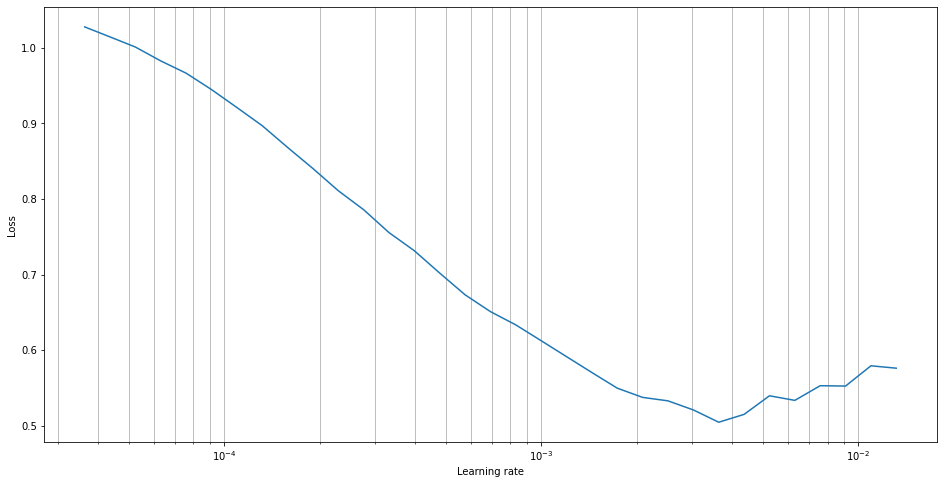

In [47]:
plot_lr_finder(lrs, losses, skip_start = 30, skip_end = 30)


In [31]:
FOUND_LR = 1e-3

params = [
          {'params': model.conv1.parameters(), 'lr': FOUND_LR / 10},
          {'params': model.bn1.parameters(), 'lr': FOUND_LR / 10},
          {'params': model.layer1.parameters(), 'lr': FOUND_LR / 8},
          {'params': model.layer2.parameters(), 'lr': FOUND_LR / 6},
          {'params': model.layer3.parameters(), 'lr': FOUND_LR / 4},
          {'params': model.layer4.parameters(), 'lr': FOUND_LR / 2},
          {'params': model.fc.parameters()}
         ]


optimizer = optim.Adam(params, lr = FOUND_LR)

In [32]:
EPOCHS = 24
STEPS_PER_EPOCH = len(train_iterator)
TOTAL_STEPS = EPOCHS * STEPS_PER_EPOCH

MAX_LRS = [p['lr'] for p in optimizer.param_groups]

scheduler = lr_scheduler.OneCycleLR(optimizer,
                                    max_lr = MAX_LRS,
                                    total_steps = TOTAL_STEPS)

In [33]:
from sklearn.metrics import precision_score, recall_score, f1_score


def calculate_topk_accuracy(y_pred, y, k = 2):
    with torch.no_grad():
        batch_size = y.shape[0]
        _, top_pred = y_pred.topk(k, 1)
        top_pred = top_pred.t()
        correct = top_pred.eq(y.view(1, -1).expand_as(top_pred))
        correct_1 = correct[:1].reshape(-1).float().sum(0, keepdim = True)
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim = True)
        acc_1 = correct_1 / batch_size
        acc_k = correct_k / batch_size
    return acc_1, acc_k

def calculate_metrics(pred, target, threshold=0.5):

    pred = np.array(pred > threshold, dtype=float)

    pred_flat = np.argmax(pred, 1)

    return {'weighted/precision': precision_score(y_true=target, y_pred=pred_flat, average='weighted'),

            'weighted/recall': recall_score(y_true=target, y_pred=pred_flat, average='weighted'),

            'weighted/f1': f1_score(y_true=target, y_pred=pred_flat, average='weighted'),

            }

In [34]:
def train(model, ema_model,  iterator, optimizer, criterion, scheduler, device):
    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    model_result = []
    targets = []
    model.train()
    
    for (x, y) in iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        y_pred = model(x)
        
        loss = criterion(y_pred, y)
        
        acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)
        
        loss.backward()
        ema_model.update(model)

        optimizer.step()
        
        scheduler.step()
        
        epoch_loss += loss.item()
        epoch_acc_1 += acc_1.item()
        epoch_acc_5 += acc_5.item()
        model_result.extend(y_pred.cpu().detach().numpy())
        targets.extend(y.cpu().numpy())
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
    results = calculate_metrics(np.array(model_result),np.array(targets))

    print(' Train Loss: {:.4f} Precision: {:.4f} Recall: {:.4f} F1: {:.4f}'.format(
                 epoch_loss, results['weighted/precision'],results['weighted/recall'], results['weighted/f1']))
    
    return epoch_loss, epoch_acc_1, epoch_acc_5

In [35]:
def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    model_resultt = []
    targetss = []
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)
            y_pred = model(x)
          
            loss = criterion(y_pred, y)

            acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc_1 += acc_1.item()
            epoch_acc_5 += acc_5.item()
            model_resultt.extend(y_pred.cpu().detach().numpy())
            targetss.extend(y.cpu().numpy())
    results = calculate_metrics(np.array(model_resultt),np.array(targetss))

    print('\t val_Precision: {:.4f} val_Recall: {:.4f} val_F1: {:.4f}'.format(
                  results['weighted/precision'],results['weighted/recall'], results['weighted/f1']))
            
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
        
    return epoch_loss, epoch_acc_1, epoch_acc_5, results['weighted/f1']

In [36]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [60]:
import wandb
#wandb.init(project =  "door_classification", entity = "voxel-wandb", config = None)


config_defaults = {
        'project' : "RESNET-model-",
        'num_epochs': 24,
        'batch_size': 128,
        'learning_rate': 1e-3,
        'ema':True,
        'stodepth':True,
        'smouth':True,
        'aug':True,
        'SGD':True,
    }
best_valid_loss = float('inf')

ema_model = ModelEMA(model) 
wandb.login(key='5a3ade2f4b7473a2e9c8a463138793a6e0c7e548')
wandb.init(config=config_defaults)

for epoch in range(EPOCHS):
    
    start_time = time.monotonic()
    print(f'Epoch: {epoch+1:02}')

    train_loss, train_acc_1, train_acc_5 = train(model, ema_model, train_iterator, optimizer, criterion, scheduler, device)

    wandb.log({"train loss":train_loss})
    print(f'\tTrain Acc @1: {train_acc_1*100:6.2f}% | ' f'Train Acc @2: {train_acc_5*100:6.2f}%')   


    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'\tEpoch Time: {epoch_mins}m {epoch_secs}s')

    
    
    
    valid_loss, valid_acc_1, valid_acc_5, val_f1 = evaluate(model, valid_iterator, criterion, device)
    
    wandb.log({"val loss":valid_loss})
    wandb.log({"val_f1":val_f1})    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'door_classifier_best-model-base-EMA2.pt')

    best_model_wts = copy.deepcopy(model.state_dict())
    model.load_state_dict(best_model_wts)
    example_input = torch.randn(1, 3, 224, 224, requires_grad=False).to(device)
    traced_model = torch.jit.trace(model, example_input)
    today_date = datetime.today().strftime('%Y-%m-%d')
    traced_model.save('door_classifier_best-model-base-EMA2_JIT.pth')
   
    print(f'\t Valid Loss: {valid_loss:.3f} | Valid Acc @1: {valid_acc_1*100:6.2f}% | ' f'Valid Acc @2: {valid_acc_5*100:6.2f}%')

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


train loss,█▇▅▅▃▁▁▁▁
val loss,█▁▁▄▂▁▂▁▁
val_f1,▁▇▇▇▇▆▆██
train loss,0.00142
val loss,0.05403
val_f1,0.98942


wandb: wandb version 0.12.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch: 01
 Train Loss: 0.0011 Precision: 0.9991 Recall: 0.9991 F1: 0.9991
	Train Acc @1:  99.96% | Train Acc @2: 100.00%
	Epoch Time: 6m 43s
	 val_Precision: 0.9886 val_Recall: 0.9886 val_F1: 0.9883
	 Valid Loss: 0.056 | Valid Acc @1:  98.73% | Valid Acc @2: 100.00%
Epoch: 02
 Train Loss: 0.0009 Precision: 0.9991 Recall: 0.9991 F1: 0.9991
	Train Acc @1:  99.98% | Train Acc @2: 100.00%
	Epoch Time: 6m 51s
	 val_Precision: 0.9874 val_Recall: 0.9874 val_F1: 0.9871
	 Valid Loss: 0.051 | Valid Acc @1:  98.78% | Valid Acc @2: 100.00%
Epoch: 03
 Train Loss: 0.0010 Precision: 0.9992 Recall: 0.9992 F1: 0.9992
	Train Acc @1:  99.97% | Train Acc @2: 100.00%
	Epoch Time: 6m 52s
	 val_Precision: 0.9889 val_Recall: 0.9889 val_F1: 0.9885
	 Valid Loss: 0.054 | Valid Acc @1:  98.79% | Valid Acc @2: 100.00%
Epoch: 04
 Train Loss: 0.0014 Precision: 0.9992 Recall: 0.9992 F1: 0.9991
	Train Acc @1:  99.95% | Train Acc @2: 100.00%
	Epoch Time: 6m 51s
	 val_Precision: 0.9886 val_Recall: 0.9886 val_F1: 0.9883


In [37]:
#TEST ON THE TESTING DATASET SPLIT
jit=False
test_iterator = data.DataLoader(test_data, batch_size = BATCH_SIZE)
if jit==False:
      model.load_state_dict(torch.load('/home/nasha_voxelsafety_com/voxel/experimental/nasha/models/door_classifier/door_classifier_best-model-base-EMA.pt'))

else:
      model_jit = torch.jit.load('door_classifier_best-model-base-EMA2_JIT.pth')

test_loss, test_acc_1, test_acc_2, val_f1 = evaluate(model, test_iterator, criterion, device)
print(f'Test Loss: {test_loss:.3f} | Test Acc @1: {test_acc_1*100:6.2f}% | ' \
            f'Test Acc @2: {test_acc_2*100:6.2f}%') 


                                

	 val_Precision: 0.9937 val_Recall: 0.9936 val_F1: 0.9935
Test Loss: 0.011 | Test Acc @1:  99.66% | Test Acc @2:  99.97%


In [62]:

#TEST ON THE TESTING AMIRICOLD VIDEO
jit=False

test_dir_vid="test_vid2"
test_vid = datasets.ImageFolder(root = test_dir_vid, transform = test_transforms)
test_vid_iterator = data.DataLoader(test_vid,  batch_size = 128)

if jit==False:
      model.load_state_dict(torch.load('door_classifier_best-model-base-EMA2.pt'))

else:
      model_jit = torch.jit.load('door_classifier_best-model-base-EMA2_JIT.pth')
test_loss, test_acc_1, test_acc_2, val_f1 = evaluate(model, test_vid_iterator, criterion, device)
print(f'Test Loss: {test_loss:.3f} | Test Acc @1: {test_acc_1*100:6.2f}% | ' \
            f'Test Acc @2: {test_acc_2*100:6.2f}%') 




FileNotFoundError: [Errno 2] No such file or directory: 'test_vid2'

In [ ]:
def get_predictions(model, iterator):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred,_ = model(x)

            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs

In [ ]:
images, labels, probs = get_predictions(model, test_vid_iterator)


In [ ]:
pred_labels = torch.argmax(probs, 1)


In [ ]:

def plot_confusion_matrix(labels, pred_labels, classes):
    
    fig = plt.figure();
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, display_labels = classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
  


In [ ]:
plot_confusion_matrix(labels, pred_labels, classes)


In [ ]:
incorrect_examples = []
corrects = torch.eq(labels, pred_labels)
for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse = True, key = lambda x: torch.max(x[2], dim = 0).values)
print(len(incorrect_examples))

In [ ]:
def plot_most_incorrect(incorrect, classes, n_images, normalize = True):

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (25, 20))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image, true_label, probs = incorrect[i]
        image = image.permute(1, 2, 0)
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim = 0)
        true_class = classes[true_label]
        incorrect_class = classes[incorrect_label]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.cpu().numpy())
        ax.set_title(f'true label: {true_class} ({true_prob:.3f})\n' \
                     f'pred label: {incorrect_class} ({incorrect_prob:.3f})')
        ax.axis('off')
        
    fig.subplots_adjust(hspace=0.4)

In [ ]:
N_IMAGES = len(incorrect_examples)

plot_most_incorrect(incorrect_examples, classes, N_IMAGES)

wandb: Network error (ReadTimeout), entering retry loop.
